# Google Earth Engine to GeoCroissant Support

<img src="../asset/GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 50px;">

## Overview

This notebook demonstrates how to convert Google Earth Engine (GEE) satellite imagery assets into GeoCroissant format - a specialized extension of the ML Commons Croissant standard for geospatial datasets. 

## Authenticate and Initialize Earth Engine

This cell authenticates to Google Earth Engine using a service account and initializes the `ee` Python API for further operations.

In [6]:
!pip install earthengine-api -q

In [7]:
import ee
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    "./code-earthengine.json",
    scopes=["https://www.googleapis.com/auth/earthengine"],
)
ee.Initialize(credentials=credentials)

## Check Asset Metadata via REST API

This cell uses the REST API and your access token to fetch and print the metadata for a specific Earth Engine asset.

In [8]:
import requests

token = credentials.token

# API CHECK
url = "https://earthengine.googleapis.com/v1alpha/projects/earthengine-public/assets/COPERNICUS/S2/20170430T190351_20170430T190351_T10SEG"
headers = {"Authorization": f"Bearer {token}"}
response = requests.get(url, headers=headers)
print(response.json())

{'type': 'IMAGE', 'name': 'projects/earthengine-public/assets/COPERNICUS/S2/20170430T190351_20170430T190351_T10SEG', 'id': 'COPERNICUS/S2/20170430T190351_20170430T190351_T10SEG', 'properties': {'DATATAKE_IDENTIFIER': 'GS2A_20170430T190351_009691_N05.00', 'SPACECRAFT_NAME': 'Sentinel-2A', 'RADIO_ADD_OFFSET_B8A': -1000, 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A': 114.911147676295, 'RADIO_ADD_OFFSET_B10': -1000, 'MEAN_SOLAR_AZIMUTH_ANGLE': 144.166615587836, 'SOLAR_IRRADIANCE_B12': 85.25, 'SOLAR_IRRADIANCE_B10': 367.15, 'SENSOR_QUALITY': 'PASSED', 'SOLAR_IRRADIANCE_B11': 245.59, 'GENERATION_TIME': 1695535572000, 'RADIO_ADD_OFFSET_B12': -1000, 'RADIO_ADD_OFFSET_B11': -1000, 'SOLAR_IRRADIANCE_B8A': 955.32, 'FORMAT_CORRECTNESS': 'PASSED', 'CLOUD_COVERAGE_ASSESSMENT': 0.255852831116763, 'SNOW_PIXEL_PERCENTAGE': 0.00209765272659894, 'RADIO_ADD_OFFSET_B1': -1000, 'RADIO_ADD_OFFSET_B2': -1000, 'DATASTRIP_ID': 'S2A_OPER_MSI_L1C_DS_S2RP_20230924T060612_S20170430T190351_N05.00', 'RADIO_ADD_OFFSET_B3': -1000

## Convert Earth Engine Asset Metadata to GeoCroissant JSON-LD

This cell:
- Authenticates to Earth Engine,
- Fetches asset metadata,
- Computes the bounding box and WKT geometry,
- Builds a per-band asset dictionary,
- Assembles a GeoCroissant-compliant JSON-LD object,
- Saves it to `gee.json`.

In [9]:
import ee
from google.oauth2 import service_account
from google.auth.transport.requests import Request
import json
import datetime

# 1. Authenticate to Earth Engine
SERVICE_ACCOUNT_FILE = "code-earthengine.json"
ASSET_ID = "COPERNICUS/S2/20170430T190351_20170430T190351_T10SEG"

creds = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=["https://www.googleapis.com/auth/earthengine"]
)
creds.refresh(Request())
ee.Initialize(credentials=creds)
token = creds.token

# 2. Fetch asset metadata
meta = ee.data.getAsset(ASSET_ID)
props = meta["properties"]

# 3. Compute bounding box
coords = meta["geometry"]["coordinates"][0]
lons, lats = zip(*coords)
bbox = f"{min(lats)} {min(lons)} {max(lats)} {max(lons)}"
wkt = "POLYGON((" + ", ".join(f"{x} {y}" for x, y in coords) + "))"

# 4. Build per-band assets
assets = {}
for band in meta["bands"]:
    band_id = band["id"]
    res = band["grid"]["affineTransform"]["scaleX"]
    assets[band_id] = {
        "href": f"ee://{ASSET_ID}/{band_id}",
        "type": "image/tiff",
        "roles": ["data"],
        "band_name": band_id,
        "data_type": band["dataType"]["precision"].lower(),
        "spatial_resolution": res,
        "description": f"Sentinel-2 band {band_id} of image {ASSET_ID}",
    }

# 5. Convert bbox to array format
bbox_coords = [min(lons), min(lats), max(lons), max(lats)]

# 6. Build fileSet for the bands
fileSet_id = f"sentinel2-bands-{ASSET_ID.replace('/', '-')}"
band_files = []
for band in meta["bands"]:
    band_files.append(
        {
            "name": f"{band['id']}.tif",
            "path": f"ee://{ASSET_ID}/{band['id']}",
            "contentSize": (
                band.get("dimensions", {}).get("width", 0)
                * band.get("dimensions", {}).get("height", 0)
                * 2
            ),  # Approximate size
        }
    )

# 7. Assemble Geo-Croissant JSON-LD (using correct prefixes & geocr IRIs)
geo_croissant = {
    "@context": {
        "@language": "en",
        "@vocab": "https://schema.org/",
        "citeAs": "cr:citeAs",
        "column": "cr:column",
        "conformsTo": "dct:conformsTo",
        "cr": "http://mlcommons.org/croissant/",
        "geocr": "http://mlcommons.org/croissant/geo/",
        "rai": "http://mlcommons.org/croissant/RAI/",
        "dct": "http://purl.org/dc/terms/",
        "sc": "https://schema.org/",
        "data": {"@id": "cr:data", "@type": "@json"},
        "examples": {"@id": "cr:examples", "@type": "@json"},
        "dataBiases": "cr:dataBiases",
        "dataCollection": "cr:dataCollection",
        "dataType": {"@id": "cr:dataType", "@type": "@vocab"},
        "extract": "cr:extract",
        "field": "cr:field",
        "fileProperty": "cr:fileProperty",
        "fileObject": "cr:fileObject",
        "fileSet": "cr:fileSet",
        "format": "cr:format",
        "includes": "cr:includes",
        "isLiveDataset": "cr:isLiveDataset",
        "jsonPath": "cr:jsonPath",
        "key": "cr:key",
        "md5": "cr:md5",
        "parentField": "cr:parentField",
        "path": "cr:path",
        "personalSensitiveInformation": "cr:personalSensitiveInformation",
        "recordSet": "cr:recordSet",
        "references": "cr:references",
        "regex": "cr:regex",
        "repeated": "cr:repeated",
        "replace": "cr:replace",
        "samplingRate": "cr:samplingRate",
        "separator": "cr:separator",
        "source": "cr:source",
        "subField": "cr:subField",
        "transform": "cr:transform",
    },
    "@type": "sc:Dataset",
    "name": ASSET_ID.replace("/", "_"),
    "alternateName": [
        ASSET_ID.replace("/", "-"),
        f"Sentinel-2-{props.get('MGRS_TILE', '')}",
    ],
    "description": (
        f"Sentinel-2 Level-1C image over MGRS tile {props.get('MGRS_TILE','')} acquired"
        f" on {meta['startTime'][:10]}. This dataset contains"
        f" {len(meta['bands'])} spectral bands with spatial resolutions ranging from"
        " 10m to 60m."
    ),
    "conformsTo": [
        "http://mlcommons.org/croissant/1.0",
        "http://mlcommons.org/croissant/geo/1.0"
    ],
    "version": "1.0.0",
    "creator": {
        "@type": "Organization",
        "name": "European Space Agency (ESA)",
        "url": "https://www.esa.int/",
    },
    "url": f"https://earthengine.googleapis.com/v1alpha/projects/earthengine-public/assets/{ASSET_ID}",
    "keywords": [
        "Sentinel-2",
        "satellite imagery",
        "remote sensing",
        "multispectral",
        "Earth observation",
        f"MGRS-{props.get('MGRS_TILE', '')}",
        "Level-1C",
        "ESA",
        "Copernicus",
    ],
    "citeAs": f"https://earthengine.googleapis.com/v1alpha/projects/earthengine-public/assets/{ASSET_ID}",
    "datePublished": meta["startTime"][:10],
    "license": "https://creativecommons.org/licenses/by/4.0/",
    "spatialCoverage": {
        "@type": "Place",
        "geo": {
            "@type": "GeoShape",
            "box": f"{min(lats)} {min(lons)} {max(lats)} {max(lons)}"
        }
    },
    "temporalCoverage": f"{meta['startTime']}/{meta['endTime']}",
    "geocr:spatialResolution": "10-60m",
    "geocr:coordinateReferenceSystem": "EPSG:4326",
    "variableMeasured": [
        {
            "@type": "sc:PropertyValue",
            "sc:name": "Cloudy pixel percentage",
            "sc:value": props.get("CLOUDY_PIXEL_PERCENTAGE", 0),
        },
        {
            "@type": "sc:PropertyValue",
            "sc:name": "Cloud coverage assessment",
            "sc:value": props.get("CLOUD_COVERAGE_ASSESSMENT", 0),
        },
    ],
    "recordSet": [
        {
            "@type": "cr:RecordSet",
            "@id": f"sentinel2_bands_{ASSET_ID.replace('/', '_')}",
            "name": f"sentinel2_bands_{ASSET_ID.replace('/', '_')}",
            "description": f"Spectral bands for Sentinel-2 image {ASSET_ID}",
            "field": [
                {
                    "@type": "cr:Field",
                    "@id": f"{ASSET_ID.replace('/', '_')}/asset_id",
                    "name": f"{ASSET_ID.replace('/', '_')}/asset_id",
                    "description": "Asset identifier",
                    "dataType": "sc:Text",
                    "source": {
                        "fileSet": {"@id": fileSet_id},
                        "extract": {"fileProperty": "fullpath"},
                    },
                },
                {
                    "@type": "cr:Field",
                    "@id": f"{ASSET_ID.replace('/', '_')}/image_data",
                    "name": f"{ASSET_ID.replace('/', '_')}/image_data",
                    "description": "Satellite imagery data",
                    "dataType": "sc:ImageObject",
                    "source": {
                        "fileSet": {"@id": fileSet_id},
                        "extract": {"fileProperty": "fullpath"},
                    },
                    "geocr:bandConfiguration": {
                        "@type": "geocr:BandConfiguration",
                        "geocr:totalBands": len(meta["bands"]),
                        "geocr:bandNameList": [band["id"] for band in meta["bands"]],
                    },
                },
            ],
        }
    ],
    "fileSet": [
        {
            "@type": "cr:FileSet",
            "@id": fileSet_id,
            "name": fileSet_id,
            "description": f"Sentinel-2 spectral bands for {ASSET_ID}",
            "includes": "*.tif",
            "encodingFormat": "image/tiff",
            "fileObject": [
                {
                    "@type": "cr:FileObject",
                    "name": f"{band['id']}.tif",
                    "contentUrl": f"https://earthengine.googleapis.com/v1alpha/projects/earthengine-public/assets/{ASSET_ID}/{band['id']}",
                    "encodingFormat": "image/tiff",
                    "contentSize": (
                        band.get("dimensions", {}).get("width", 0)
                        * band.get("dimensions", {}).get("height", 0)
                        * 2
                    ),
                }
                for band in meta["bands"]
            ],
        }
    ],
    "distribution": [
        {
            "@type": "cr:FileObject",
            "@id": f"sentinel2-bands-{ASSET_ID.replace('/', '-')}",
            "name": f"Sentinel-2 Bands for {ASSET_ID}",
            "description": f"Downloadable Sentinel-2 spectral bands for {ASSET_ID}",
            "contentUrl": f"https://earthengine.googleapis.com/v1alpha/projects/earthengine-public/assets/{ASSET_ID}",
            "encodingFormat": "application/json",
        }
    ],
}

# 8. Write to file
with open("gee.json", "w") as f:
    json.dump(geo_croissant, f, indent=2)

print("Geo-Croissant JSON-LD saved to gee.json")

Geo-Croissant JSON-LD saved to gee.json


## Pretty Print GeoCroissant JSON-LD

This cell loads and pretty-prints the contents of `gee.json` for easy inspection.

In [10]:
import json

# Load and pretty-print the content of croissant.json
with open("gee.json", "r") as f:
    croissant_data = json.load(f)

# Pretty-print JSON to console
print(json.dumps(croissant_data, indent=2))

{
  "@context": {
    "@language": "en",
    "@vocab": "https://schema.org/",
    "citeAs": "cr:citeAs",
    "column": "cr:column",
    "conformsTo": "dct:conformsTo",
    "cr": "http://mlcommons.org/croissant/",
    "geocr": "http://mlcommons.org/croissant/geo/",
    "rai": "http://mlcommons.org/croissant/RAI/",
    "dct": "http://purl.org/dc/terms/",
    "sc": "https://schema.org/",
    "data": {
      "@id": "cr:data",
      "@type": "@json"
    },
    "examples": {
      "@id": "cr:examples",
      "@type": "@json"
    },
    "dataBiases": "cr:dataBiases",
    "dataCollection": "cr:dataCollection",
    "dataType": {
      "@id": "cr:dataType",
      "@type": "@vocab"
    },
    "extract": "cr:extract",
    "field": "cr:field",
    "fileProperty": "cr:fileProperty",
    "fileObject": "cr:fileObject",
    "fileSet": "cr:fileSet",
    "format": "cr:format",
    "includes": "cr:includes",
    "isLiveDataset": "cr:isLiveDataset",
    "jsonPath": "cr:jsonPath",
    "key": "cr:key",
    "

## Validate GeoCroissant JSON-LD

This cell runs the `mlcroissant` validator on your GeoCroissant JSON-LD file to check for schema compliance.

In [11]:
!mlcroissant validate --jsonld=gee.json

E0216 19:08:31.570067 127957704201728 validate.py:55] Found the following 1 error(s) during the validation:
  -  "_:a2fec96d-5ae9-49b5-b32d-9327d74d63ca" should have an attribute "@type": "https://schema.org/Text". Got None instead.


## Visualize Earth Engine Asset and Thumbnails

This cell:
- Loads the GeoCroissant JSON-LD,
- Extracts the Earth Engine asset ID,
- Authenticates and initializes Earth Engine,
- Loads the image and centers a map,
- Adds true-color and additional band layers,
- Generates and displays RGB and band thumbnails,
- Displays an interactive map using geemap.

  Shape: (512, 512, 2), dtype: uint8
  Shape: (512, 512, 2), dtype: uint8
  Shape: (512, 512, 2), dtype: uint8
  Shape: (512, 512, 2), dtype: uint8
  Shape: (512, 512, 2), dtype: uint8
  Shape: (512, 512, 2), dtype: uint8


/tmp/ipykernel_84283/475376457.py:108: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


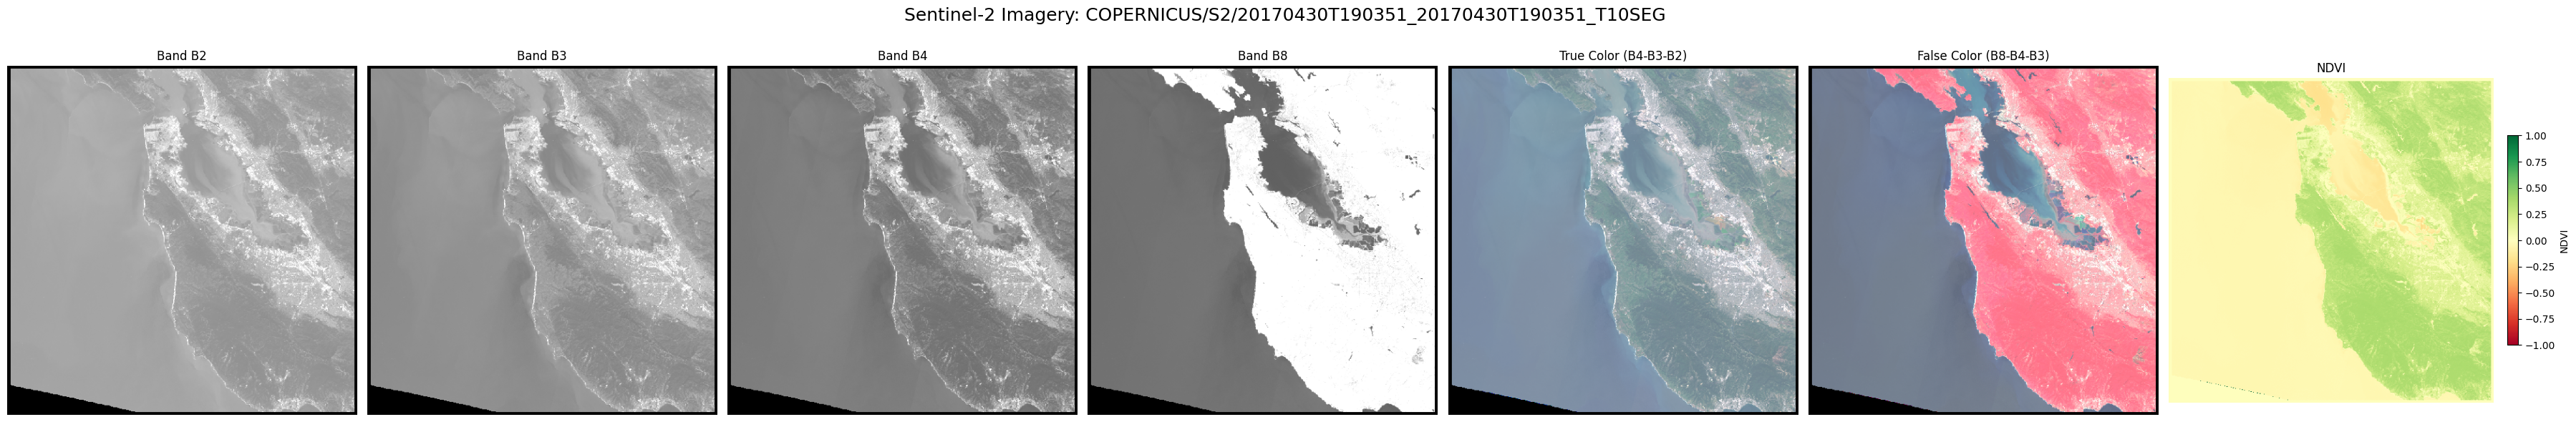

In [13]:
import ee
import json
import numpy as np
import matplotlib.pyplot as plt
from google.oauth2 import service_account
from google.auth.transport.requests import Request
import requests
from PIL import Image
import io

# 1. Load Geo-Croissant JSON-LD
with open("gee.json") as f:
    md = json.load(f)

# 2. Extract EE asset ID
parts = md["url"].split("/")
ee_id = "/".join(
    parts[-3:]
)  # e.g. "COPERNICUS/S2/20170430T190351_20170430T190351_T10SEG"

# 3. Authenticate & init EE
SERVICE_ACCOUNT_FILE = "code-earthengine.json"
creds = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=["https://www.googleapis.com/auth/earthengine"]
)
creds.refresh(Request())
ee.Initialize(credentials=creds)

# 4. Load image and get metadata
img = ee.Image(ee_id)
geometry = img.geometry()
bounds = geometry.bounds().getInfo()["coordinates"][0]

# 5. Get image dimensions and create a region
region = geometry.buffer(1000)  # Buffer by 1km


# 6. Function to download band data as numpy array
def download_band_as_array(band_name, region, scale=30):
    """Download a single band from Earth Engine as numpy array"""
    band_img = img.select(band_name)
    thumb_url = band_img.getThumbURL(
        {"region": region, "dimensions": 512, "format": "png", "min": 0, "max": 3000}
    )
    response = requests.get(thumb_url)
    pil_image = Image.open(io.BytesIO(response.content))
    array = np.array(pil_image)
    return array


# 7. Download bands for visualization
print("Downloading band data...")
bands_to_visualize = ["B2", "B3", "B4", "B8", "B11", "B12"]
band_data = {}

for band in bands_to_visualize:
    print(f"Downloading {band}...")
    band_data[band] = download_band_as_array(band, region)
    print(f"  Shape: {band_data[band].shape}, dtype: {band_data[band].dtype}")


# 8. Create RGB composite
def create_rgb_composite(band_data, red_band="B4", green_band="B3", blue_band="B2"):
    red = band_data[red_band]
    green = band_data[green_band]
    blue = band_data[blue_band]
    if red.ndim == 3:
        red = red[:, :, 0]
    if green.ndim == 3:
        green = green[:, :, 0]
    if blue.ndim == 3:
        blue = blue[:, :, 0]
    red_norm = red.astype(np.float32) / 255.0
    green_norm = green.astype(np.float32) / 255.0
    blue_norm = blue.astype(np.float32) / 255.0
    rgb = np.stack([red_norm, green_norm, blue_norm], axis=2)
    return rgb


# 9. Create false color composite (NIR-Red-Green)
def create_false_color_composite(
    band_data, red_band="B8", green_band="B4", blue_band="B3"
):
    red = band_data[red_band]
    green = band_data[green_band]
    blue = band_data[blue_band]
    if red.ndim == 3:
        red = red[:, :, 0]
    if green.ndim == 3:
        green = green[:, :, 0]
    if blue.ndim == 3:
        blue = blue[:, :, 0]
    red_norm = red.astype(np.float32) / 255.0
    green_norm = green.astype(np.float32) / 255.0
    blue_norm = blue.astype(np.float32) / 255.0
    fcc = np.stack([red_norm, green_norm, blue_norm], axis=2)
    return fcc


# 10. Calculate NDVI
def calculate_ndvi(band_data, nir_band="B8", red_band="B4"):
    nir = band_data[nir_band].astype(np.float32)
    red = band_data[red_band].astype(np.float32)
    if nir.ndim == 3:
        nir = nir[:, :, 0]
    if red.ndim == 3:
        red = red[:, :, 0]
    ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))
    return ndvi


# 11. Combined visualization: B2, B3, B4, B8, True Color, False Color, NDVI
rgb_composite = create_rgb_composite(band_data)
false_color = create_false_color_composite(band_data)
ndvi = calculate_ndvi(band_data)

fig, axes = plt.subplots(1, 7, figsize=(36, 6))
fig.suptitle(f"Sentinel-2 Imagery: {ee_id}", fontsize=18)

# Bands B2, B3, B4, B8
for i, band in enumerate(["B2", "B3", "B4", "B8"]):
    band_img = band_data[band]
    if band_img.ndim == 3:
        band_img = band_img[:, :, 0]
    axes[i].imshow(band_img, cmap="gray")
    axes[i].set_title(f"Band {band}")
    axes[i].axis("off")

# True Color
axes[4].imshow(rgb_composite)
axes[4].set_title("True Color (B4-B3-B2)")
axes[4].axis("off")

# False Color
axes[5].imshow(false_color)
axes[5].set_title("False Color (B8-B4-B3)")
axes[5].axis("off")

# NDVI
im = axes[6].imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
axes[6].set_title("NDVI")
axes[6].axis("off")
fig.colorbar(im, ax=axes[6], fraction=0.03, pad=0.04, label="NDVI")

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()